In [1]:
import os
import pickle
import json
from copy import deepcopy
import hashlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
from src.datajoint.datajoint_config import *

[2023-02-07 20:33:47,990][INFO]: Connecting ptolmachev@localhost:3306
[2023-02-07 20:33:48,015][INFO]: Connected ptolmachev@localhost:3306


In [2]:
# rnn_dj  = RNNDJ()
# task_dj  = TaskDJ()
# trainer_dj  = TrainerDJ()
# # trainer_dj.drop()

In [3]:
def jsonify(dct):
    dct_jsonified = {}
    for key in list(dct.keys()):
        if type(dct[key]) == type({}):
            dct_jsonified[key] = jsonify(dct[key])
        elif type(dct[key]) == np.ndarray:
            dct_jsonified[key] = dct[key].tolist()
        else:
            dct_jsonified[key] = dct[key]
    return dct_jsonified

def get_hash(dictionary):
    dictionary_json = json.dumps(dictionary, sort_keys=True).encode("utf-8")
    h = hashlib.md5(dictionary_json).hexdigest()[:16]
    return h

In [4]:
folder = os.path.join("../", 'data', 'trained_RNNs', 'CDDM')
subfolders = os.listdir(folder)
for subfolder in subfolders:
    if not subfolder.startswith('.'):
        for file in list(os.listdir(os.path.join(folder, subfolder))):
            if 'params' in file:
                score = file.split('_')[-1].split(".pkl")[0]
                taskname = file.split('_')[1]
        print(subfolder)
        config_dict = json.load(open(os.path.join(folder, subfolder, f'{score}_config.json'), 'rb'))
        net_params_file = os.path.join(folder, subfolder, f'params_CDDM_{score}.pkl')
        net_params = pickle.load(open(net_params_file, 'rb'))
        
        LA_data_file = os.path.join(folder, subfolder, f'{score}_LA_data.pkl')
        LA_data_file_exists = os.path.exists(LA_data_file)
        LA_data = pickle.load(open(LA_data_file, 'rb')) if LA_data_file_exists else None
        
        fp_data_file = os.path.join(folder, subfolder, f'{score}_fp_data.pkl')
        fp_data_file_exists = os.path.exists(fp_data_file)
        fp_data = pickle.load(open(fp_data_file, 'rb')) if fp_data_file_exists else None
        
        psycho_data_file = os.path.join(folder, subfolder, f'{score}_psycho_data.pkl')
        psycho_data_file_exists = os.path.exists(fp_data_file)
        psycho_data = pickle.load(open(psycho_data_file, 'rb')) if psycho_data_file_exists else None
        
#         if psycho_data is None: print('found no psycho_data file!') 
#         if fp_data is None: print('found no fp_data file!') 
#         if LA_data is None: print('found no LA_data file!') 
        
        if (psycho_data is None) or (fp_data is None) or (LA_data is None):
            pass # skip this entry
        else:
            rnn_dj = RNNDJ()
            task_dj = TaskDJ()
            trainer_dj = TrainerDJ()
            config_dict["task_params"]["seed"] = None
            task_dj_dict = {"task_name": taskname,
                            "n_steps": config_dict["n_steps"],
                            "n_inputs": config_dict["num_inputs"],
                            "n_outputs": config_dict["num_outputs"],
                            "task_params": config_dict["task_params"],
                            "mask": config_dict["mask"]}
            task_hash = get_hash(jsonify(task_dj_dict))
            task_dj_dict["task_hash"] = task_hash
            
            trainer_dj_dict = {"max_iter": config_dict["max_iter"],
                               "tol": config_dict["tol"],
                               "lr": config_dict["lr"],
                               "lambda_orth": config_dict["lambda_orth"],
                               "lambda_r": config_dict["lambda_r"],
                               "same_batch" : config_dict["same_batch"],
                               "shuffle" : False}
            trainer_hash = get_hash(jsonify(trainer_dj_dict))
            trainer_dj_dict["trainer_hash"] = trainer_hash
            
            rnn_dj_dict = {"task_name": taskname,
                           "mse_score": score,
                           "timestamp" : subfolder,
                           "n": config_dict["N"],
                           "activation_name": config_dict["activation"],
                           "constrained": config_dict["constrained"],
                           "dt": config_dict["dt"],
                           "tau": config_dict["tau"],
                           "sr": config_dict["sr"],
                           "connectivity_density_rec": config_dict["connectivity_density_rec"],
                           "sigma_rec" : config_dict["sigma_rec"],
                           "sigma_inp": config_dict["sigma_inp"],
                           "task_hash" : task_hash,
                           "trainer_hash": trainer_hash}
            rnn_dj_dict["w_inp"] = net_params["W_inp"]
            rnn_dj_dict["w_rec"] = net_params["W_rec"]
            rnn_dj_dict["w_out"] = net_params["W_out"]
            rnn_dj_dict["b_rec"] = 0 if net_params["bias_rec"] is None else net_params["bias_rec"]
            rnn_hash = get_hash(jsonify(rnn_dj_dict))
            rnn_dj_dict["rnn_hash"] = rnn_hash
            rnn_dj_dict["psycho_data"] = deepcopy(psycho_data)
            rnn_dj_dict["psycho_data"] = deepcopy(fp_data)
            rnn_dj_dict["la_data"] = deepcopy(LA_data)


            task_dj.insert1(task_dj_dict, skip_duplicates=True)
            trainer_dj.insert1(trainer_dj_dict, skip_duplicates=True)
            rnn_dj.insert1(rnn_dj_dict, skip_duplicates=True)
            print(f"successfully created new entry!")

20230201-02340922
successfully created new entry!
20230201-23004032
successfully created new entry!
20230202-02112786
successfully created new entry!
20230201-13113671
20230206-22563968
successfully created new entry!
20230131-2038343
successfully created new entry!
20230201-23030238
successfully created new entry!
20230207-03414135
successfully created new entry!
20230202-02120688
successfully created new entry!
20230131-23492770
successfully created new entry!
20230201-10135611
successfully created new entry!
20230207-06170372
successfully created new entry!
20230201-10230514
successfully created new entry!
20230202-02131390
successfully created new entry!
20230202-1103494
successfully created new entry!
20230206-2319035
successfully created new entry!
20230207-04435454
successfully created new entry!
20230202-15211568
successfully created new entry!
20230201-03025237
successfully created new entry!
20230207-02520528
successfully created new entry!
20230206-20522139
successfully crea

successfully created new entry!
20230202-14471755
successfully created new entry!
20230202-02173896
successfully created new entry!
20230201-03455267
successfully created new entry!
20230201-1012475
successfully created new entry!
20230207-01450398
successfully created new entry!
20230202-16375377
successfully created new entry!
20230202-1103506
successfully created new entry!
20230207-04093538
successfully created new entry!
20230202-14491358
successfully created new entry!
20230207-03063132
successfully created new entry!
20230201-14505298
successfully created new entry!
20230201-13062066
20230202-17403898
successfully created new entry!
20230202-02074783
successfully created new entry!
20230202-14491360
successfully created new entry!
20230207-01043594
successfully created new entry!
20230131-1833362
successfully created new entry!
20230202-02040779
successfully created new entry!
20230201-01045884
successfully created new entry!
20230202-00421374
successfully created new entry!
202

successfully created new entry!
20230201-04341798
successfully created new entry!
20230201-23080348
successfully created new entry!
20230131-22123738
successfully created new entry!
20230206-1837494
successfully created new entry!
20230201-11290339
successfully created new entry!
20230207-00344778
successfully created new entry!
20230201-23045044
successfully created new entry!
20230201-02243012
successfully created new entry!
20230207-06251277
successfully created new entry!
20230207-00252377
successfully created new entry!
20230201-10325325
successfully created new entry!
20230202-02054080
successfully created new entry!
20230201-13352179
successfully created new entry!
20230202-00370859
20230206-20491133
successfully created new entry!
20230201-14475397
successfully created new entry!
20230202-00385366
successfully created new entry!
20230202-13381250
successfully created new entry!
20230131-23304351
successfully created new entry!
20230201-10311121
successfully created new entry!
2

successfully created new entry!
20230206-22362453
successfully created new entry!
20230202-13035439
successfully created new entry!
20230202-00322554
successfully created new entry!
20230202-11053214
successfully created new entry!
20230206-19012622
successfully created new entry!
20230201-02531332
successfully created new entry!
20230201-04200788
successfully created new entry!
20230131-20435011
successfully created new entry!
20230202-01311078
20230131-23315152
successfully created new entry!
20230207-00492386
successfully created new entry!
20230201-14380793
successfully created new entry!
20230201-04254493
successfully created new entry!
20230131-20485518
successfully created new entry!
20230131-23510772
successfully created new entry!
20230207-04323250
successfully created new entry!
20230202-16390280
successfully created new entry!
20230202-02165995
successfully created new entry!
20230207-02340417
successfully created new entry!
20230207-03040931
successfully created new entry!


successfully created new entry!
20230202-16421585
successfully created new entry!
20230201-03191852
successfully created new entry!
20230131-20495821
successfully created new entry!
20230207-06004365
successfully created new entry!
20230201-03565276
successfully created new entry!
20230207-07184481
successfully created new entry!
20230131-20474514
successfully created new entry!
20230202-1103272
successfully created new entry!
20230207-07534788
successfully created new entry!
20230202-16553289
successfully created new entry!
20230207-0103197
successfully created new entry!
20230207-00514590
successfully created new entry!
20230201-21275317
successfully created new entry!
20230202-11055616
successfully created new entry!
20230201-12265355
successfully created new entry!
20230206-22552666
successfully created new entry!
20230202-12584731
successfully created new entry!
20230206-21184849
successfully created new entry!
20230201-03261456
successfully created new entry!
20230201-21275319
su

In [5]:
(rnn_dj & 'activation_name="relu"')

task_hash,trainer_hash,rnn_hash unique model id,mse_score,task_name,timestamp,n number of nodes in the RNN,activation_name name of the activation function used in the dynamics,"constrained boolean variable, either True or False, using biologically plausible connectivity or not",dt Euler integration timestep,tau Dynamical time-scale,sr spectral radius of the recurrent conenctivity,connectivity_density_rec opposite of sparsity of the connectivity. 1 - fully connected network,sigma_rec,sigma_inp,w_inp,w_rec,w_out,b_rec,fp_data,psycho_data,la_data
3c208c803319143c,325c235ec6a23a8c,02818aff265afd52,0.0559547,CDDM,20230202-00383464,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,031f306022fb90ff,0.0580433,CDDM,20230201-21280913,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,04b75db545be397e,0.0579533,CDDM,20230202-00322553,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,08481b7650b7f6e5,0.0579291,CDDM,20230201-2128092,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0aba703a61459bb2,0.0570123,CDDM,20230201-23015335,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0b54276f6d80fa17,0.057532,CDDM,20230201-2127529,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0ba5c25db6421d01,0.0587012,CDDM,20230202-02144693,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0caa0edda7efb8b2,0.0576281,CDDM,20230202-00480677,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0d224b78adeae8d7,0.0576037,CDDM,20230202-02071782,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=
3c208c803319143c,325c235ec6a23a8c,0d5cdaacd0ea62fd,0.058344,CDDM,20230202-02131390,100,relu,1,1.0,10.0,1.2,1,0.03,0.03,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [7]:
subdata = pd.DataFrame((rnn_dj & 'activation_name="relu"').fetch("timestamp", "trainer_hash", "mse_score", order_by='mse_score'))
with pd.option_context('display.max_rows', None,):
    print(subdata)

                 0                  1                  2                  3    \
0  20230207-08111997  20230207-05584062  20230207-05411960  20230207-06000564   
1   c09f5b4d11538512   c09f5b4d11538512   c09f5b4d11538512   c09f5b4d11538512   
2           0.008362           0.008459           0.008825            0.00884   

                 4                  5                  6                  7    \
0  20230207-00572192  20230206-23461075  20230207-01300097  20230207-06390580   
1   c09f5b4d11538512   c09f5b4d11538512   c09f5b4d11538512   c09f5b4d11538512   
2           0.008936           0.008954           0.009028           0.009081   

                 8                  9    ...                520  \
0  20230207-00540291  20230207-01520299  ...  20230201-23022537   
1   c09f5b4d11538512   c09f5b4d11538512  ...   325c235ec6a23a8c   
2           0.009129           0.009255  ...           0.058985   

                 521                522               523                524  \
0

In [13]:
mse_scores = pd.DataFrame((rnn_dj & 'activation_name="relu"').fetch("mse_score", order_by="mse_score"))

(array([12., 14., 11.,  5.,  0.,  1.,  0.,  7., 10., 22., 24., 20.,  3.,
         0.,  0.,  0.,  0.,  6.,  3.,  0.,  1.,  0.,  6.,  3., 16., 32.,
        41., 24.,  5.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  3., 13., 46., 69., 30., 13., 27., 44., 16.,  2.]),
 array([0.008362  , 0.00940946, 0.01045692, 0.01150437, 0.01255183,
        0.01359929, 0.01464675, 0.01569421, 0.01674166, 0.01778912,
        0.01883658, 0.01988404, 0.0209315 , 0.02197895, 0.02302641,
        0.02407387, 0.02512133, 0.02616879, 0.02721624, 0.0282637 ,
        0.02931116, 0.03035862, 0.03140608, 0.03245353, 0.03350099,
        0.03454845, 0.03559591, 0.03664337, 0.03769082, 0.03873828,
        0.03978574, 0.0408332 , 0.04188066, 0.04292811, 0.04397557,
        0.04502303, 0.04607049, 0.04711795, 0.0481654 , 0.04921286,
        0.05026032, 0.05130778, 0.05235524, 0.05340269, 0.05445015,
        0.05549761, 0.05654507, 0.05759253, 0.05863998, 0.05968744,
        0.0607349 ]),
 <BarContainer

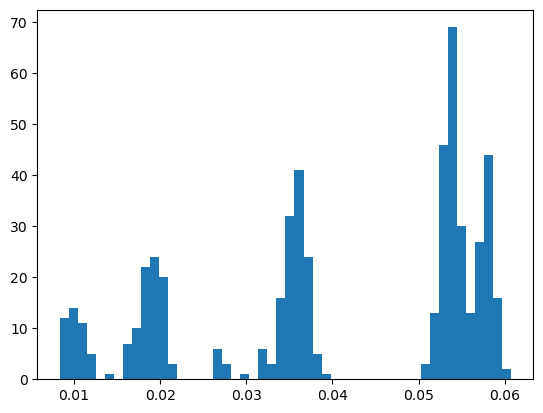

In [14]:
from matplotlib import pyplot as plt
plt.hist(mse_scores, bins = 50)

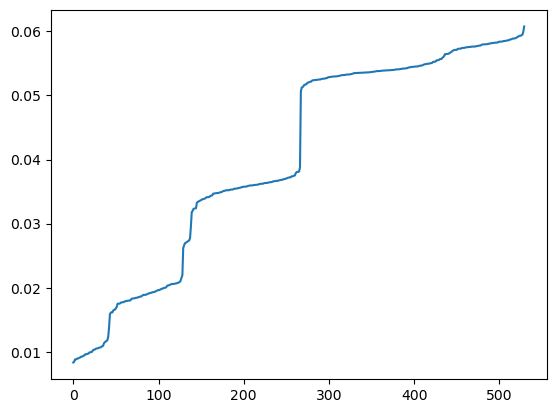

In [15]:
plt.plot(mse_scores)

In [16]:
mse_scores[:50]

,0
0,0.008362
1,0.008459
2,0.008825
3,0.008840
4,0.008936
5,0.008954
6,0.009028
7,0.009081
8,0.009129
9,0.009255
